<h3> Import libraries </h3>

In [16]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import transformers
import math
import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

torch.autograd.set_detect_anomaly(True)

from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, random_split
from torch.nn import MultiheadAttention
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import Embedding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ModuleNotFoundError: No module named 'seaborn'

<h3> Load data </h3>

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


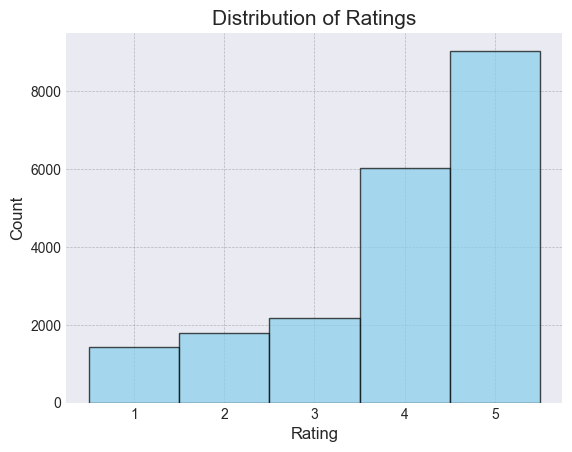

In [20]:
df = pd.read_csv('./data/unprocessed/tripadvisor_hotel_reviews.csv')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

plt.style.use('seaborn-v0_8-darkgrid')

plt.hist(df['Rating'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black', color='skyblue', alpha=0.7)

plt.title('Distribution of Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(range(1, 6))
plt.tick_params(axis='both', which='major', labelsize=10)

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()

In [12]:
class ReviewDataset(Dataset):
	def __init__(self, reviews, targets, tokenizer, max_length=512):
		self.reviews = reviews
		self.targets = targets
		self.tokenizer = tokenizer
		self.max_length = max_length

	def __len__(self):
		return len(self.reviews)

	def __getitem__(self, idx):
		review = str(self.reviews[idx])
		target = self.targets[idx]
		
		encoding = self.tokenizer.encode_plus(
			review,
			add_special_tokens=True,
			max_length=self.max_length,
			truncation=True,
			padding='max_length',
			return_attention_mask=True,
			return_token_type_ids=False,
			return_tensors='pt'
		)

		return {
			"review": encoding['input_ids'].squeeze(0),
			"attention_mask": encoding['attention_mask'].squeeze(0),
			"target": torch.tensor(target, dtype=torch.float)
		}

max_length = 100
batch_size = 8

# Create the dataset
full_dataset = ReviewDataset(df['Review'], df['Rating'], tokenizer, max_length=max_length)

# Splitting the dataset into train and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

weights = [1.0 / df.loc[idx, 'Rating'] for idx in train_dataset.indices]

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Create the DataLoader for training set using the sampler
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

# Validation DataLoader
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for data in train_dataloader:
	print(data['review'].shape)
	print(data['attention_mask'].shape)
	print(data['target'].shape)
	print("Review:", data['review'][0])
	print("Attention mask:", data['attention_mask'][0])
	print("Target:", data['target'][0])
	break

print(len(train_dataloader))

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8])
Review: tensor([  101,  3866,  1010,  7543,  2994,  2564,  4370,  6385,  5364, 12184,
         2140,  4068, 10392,  2173,  2994,  1010,  3866,  2245,  3446,  3825,
        22480,  6036,  9944,  2305,  2204,  3643,  2288,  1010,  4669,  2715,
         6055,  4734,  2282,  2288,  2047,  2307,  3193,  1010,  5723,  4550,
         2312,  2282,  3819,  2946,  1010,  7564,  9346,  5527,  2686,  1010,
         2428,  5632,  9686, 20110,  2080,  3698,  1010,  3295,  4669,  3295,
         1010,  2383,  4068,  2335,  2627,  2425,  9201,  3871,  2181,  1050,
         1005,  1056,  2919,  1010,  6534,  2100,  2395,  3257,  4089,  9511,
         3788, 15676,  9070,  2277,  2126, 13970,  1005,  5477,  2213,  2612,
         2635,  2460, 12690,  1010, 13970,  1005,  5477,  2213,  1057,   102])
Attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

<h3> Transformer Architecture </h3>

In [9]:
class TransformerBlock(nn.Module):
	def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
		super(TransformerBlock, self).__init__()
		self.att = nn.MultiheadAttention(num_heads=num_heads, embed_dim=embed_dim)
		self.ffn = nn.Sequential(
			nn.Linear(embed_dim, ff_dim),
			nn.ReLU(),
			nn.Linear(ff_dim, embed_dim),
		)
		self.layernorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
		self.layernorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
		self.dropout = nn.Dropout(rate)

	def forward(self, x, mask=None):
		# Apply multi-head attention with optional mask
		attn_output, _ = self.att(x, x, x)

		# Apply dropout to attention output
		attn_output = self.dropout(attn_output)

		# Add & Normalize
		out1 = self.layernorm1(x + attn_output)

		# Feed-forward network
		ffn_output = self.ffn(out1)

		# Add & Normalize
		out2 = self.layernorm2(out1 + ffn_output)

		# Apply dropout to entire output
		return self.dropout(out2)

class TokenAndPositionEmbedding(nn.Module):
	def __init__(self, vocab_size, embed_dim, max_length):
		super(TokenAndPositionEmbedding, self).__init__()
		self.token_emb = nn.Embedding(vocab_size, embed_dim)
		self.pos_emb = nn.Embedding(max_length, embed_dim)

	def forward(self, x):
		batch_size, seq_length = x.size()
		positions = torch.arange(0, seq_length, dtype=torch.long, device=x.device).expand(batch_size, seq_length)
		x = self.token_emb(x)
		pos = self.pos_emb(positions)
		return x + pos

class Transformer(nn.Module):
	def __init__(self, num_classes, embed_size, num_layers, heads, forward_expansion, dropout, max_length, vocab_size):
		super(Transformer, self).__init__()

		self.embedding = TokenAndPositionEmbedding(vocab_size, embed_size, max_length)
		self.layers = nn.ModuleList([TransformerBlock(embed_size, heads, forward_expansion, dropout)
										for _ in range(num_layers)])
		self.fc = nn.Linear(embed_size, num_classes)

	def forward(self, x, mask=None):
		x = self.embedding(x)
		for layer in self.layers:
			x = layer(x)
		x = torch.mean(x, dim=1)
		x = self.fc(x)
		return x

<h3> Train model </h3>

In [10]:
model = Transformer(num_classes=5, embed_size=32, num_layers=4, heads=2, forward_expansion=4, 
                        dropout=0.1, max_length=max_length, vocab_size=tokenizer.vocab_size)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train(dataloader, model, criterion, optimizer):
	model.train()
	total_loss = 0
	all_predictions = []
	all_targets = []
	pbar = tqdm.tqdm(dataloader)
	for batch_idx, batch in enumerate(pbar):
		#print(batch['review'].shape)
		#print(batch['attention_mask'].shape)
		#print(batch['target'].shape)
		#print(batch['target'])
		reviews = batch['review'].to(device)
		targets = batch['target'].long().to(device)
		targets = targets - 1
		mask = batch['attention_mask'].bool().to(device)

		optimizer.zero_grad()
		outputs = model(reviews, mask=mask)
		loss = criterion(outputs, targets)
		loss.backward()
		optimizer.step()

		total_loss += loss.item()	

		_, predicted = torch.max(outputs, 1)
		all_predictions.extend(predicted.cpu().numpy())
		all_targets.extend(targets.cpu().numpy())

	average_loss = total_loss / len(dataloader)
	accuracy = accuracy_score(all_targets, all_predictions)
	precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')

	print("Accuracy: ", accuracy)
	print("Precision: ", precision)
	print("Recall: ", recall)
	print("F1 Score: ", f1)
	print("Average Training Loss: ", average_loss)

def evaluate(dataloader, model, criterion):
	model.eval()
	total_loss = 0
	with torch.no_grad():
		for batch in dataloader:
			reviews = batch['review'].to(device)
			targets = batch['target'].long().to(device)
			targets = targets - 1
			mask = batch['attention_mask'].bool().to(device)
			
			outputs = model(reviews, mask=mask)
			loss = criterion(outputs, targets)
			total_loss += loss.item()
	average_loss = total_loss / len(dataloader)
	print("Average Evaluation Loss: ", average_loss)

for epoch in range(5):
    train(train_dataloader, model, criterion, optimizer)
    evaluate(val_dataloader, model, criterion)

100%|██████████| 257/257 [01:39<00:00,  2.58it/s]
c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.43637140068326014
Precision:  0.29898385642683245
Recall:  0.43637140068326014
F1 Score:  0.2761395575664615
Average Training Loss:  1.3547069938266323
Average Evaluation Loss:  1.3335893291693468


100%|██████████| 257/257 [01:44<00:00,  2.46it/s]
c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.4473523670082967
Precision:  0.29774485684625934
Recall:  0.4473523670082967
F1 Score:  0.3011645568148869
Average Training Loss:  1.2887365562906525
Average Evaluation Loss:  1.2588918951841501


100%|██████████| 257/257 [01:46<00:00,  2.41it/s]


Accuracy:  0.4759638848218643
Precision:  0.38040902412834465
Recall:  0.4759638848218643
F1 Score:  0.3881204982612601
Average Training Loss:  1.1896823213258143
Average Evaluation Loss:  1.1603642857991732


100%|██████████| 257/257 [01:40<00:00,  2.55it/s]


Accuracy:  0.5008540751586139
Precision:  0.43435719302812753
Recall:  0.5008540751586139
F1 Score:  0.4402238701354144
Average Training Loss:  1.1142606141502291
Average Evaluation Loss:  1.1221599927315344


100%|██████████| 257/257 [01:37<00:00,  2.64it/s]


Accuracy:  0.5206198145436799
Precision:  0.4706221293150445
Recall:  0.5206198145436799
F1 Score:  0.47452457891922617
Average Training Loss:  1.0679226475930863
Average Evaluation Loss:  1.0851301523355337


<h3> Evaluate model </h3>

In [11]:
data = {
    'Review': [
        'It was fine.',
        'Poor service and the food quality was below average.',
        'An excellent stay, the staff was friendly and the location perfect.',
        'The hotel is overpriced for the quality of the amenities provided.',
        'Great experience, the room was well-appointed and the service impeccable.',
		'Good service',
		'Bad service'
    ],
    'Rating': [3, 2, 5, 2, 5, 4, 1]
}

test_df = pd.DataFrame(data)

dataset = ReviewDataset(test_df['Review'], test_df['Rating'], tokenizer, max_length=max_length)

model.eval()

with torch.no_grad():
	for idx in range(len(dataset)):
		sample = dataset[idx]
		review = sample['review'].unsqueeze(0).to(device)
		mask = sample['attention_mask'].unsqueeze(0).bool().to(device)
		target = sample['target'].unsqueeze(0).long().to(device)
		target = target - 1

		output = model(review, mask=mask)
		probabilities = torch.softmax(output, dim=1)
		predictions = torch.argmax(probabilities, dim=1)
		print(f"Review: {test_df['Review'][idx]}")
		print(f"Actual Rating: {target[0] + 1}")
		print(f"Predicted Rating: {predictions[0] + 1}")
		print(f"Probabilities: {probabilities}")
		print()

Review: It was fine.
Actual Rating: 3
Predicted Rating: 5
Probabilities: tensor([[4.7022e-04, 3.0282e-04, 3.4865e-03, 1.0328e-01, 8.9246e-01]],
       device='cuda:0')

Review: Poor service and the food quality was below average.
Actual Rating: 2
Predicted Rating: 5
Probabilities: tensor([[8.1310e-04, 5.2863e-04, 5.3530e-03, 1.2382e-01, 8.6949e-01]],
       device='cuda:0')

Review: An excellent stay, the staff was friendly and the location perfect.
Actual Rating: 5
Predicted Rating: 5
Probabilities: tensor([[9.4529e-04, 6.7285e-04, 6.1761e-03, 1.3426e-01, 8.5794e-01]],
       device='cuda:0')

Review: The hotel is overpriced for the quality of the amenities provided.
Actual Rating: 2
Predicted Rating: 5
Probabilities: tensor([[1.1371e-03, 7.3135e-04, 6.6696e-03, 1.3476e-01, 8.5670e-01]],
       device='cuda:0')

Review: Great experience, the room was well-appointed and the service impeccable.
Actual Rating: 5
Predicted Rating: 5
Probabilities: tensor([[1.0353e-03, 7.9496e-04, 6.9648e-